In [1]:
import pandas as pd 
import pydeck as pdk
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import contextily as ctx
import networkx as nx
import copy
from tqdm import tqdm
import re

In [2]:
df_agg = pd.read_csv("../data/weekday_weekend_aggregated.csv")

In [3]:
df_agg[df_agg["Origin Station Complex Name"] == "Bryant Pk-5 Av"]


,DayType,Origin Station Complex ID,Destination Station Complex ID,mean_estimated_average_ridership,Origin Station Complex Name,Destination Station Complex Name,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude


In [4]:
df_agg.rename(columns={"mean_estimated_average_ridership": "Estimated Average Ridership"}, inplace=True)
df_agg.head()
# print(df.dtypes)

,DayType,Origin Station Complex ID,Destination Station Complex ID,Estimated Average Ridership,Origin Station Complex Name,Destination Station Complex Name,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude
0,Weekday,1,2,4.612958,"Astoria-Ditmars Blvd (N,W)","Astoria Blvd (N,W)",40.775036,-73.912034,40.770258,-73.917843
1,Weekday,1,3,10.576542,"Astoria-Ditmars Blvd (N,W)","30 Av (N,W)",40.775036,-73.912034,40.766779,-73.921479
2,Weekday,1,4,10.150664,"Astoria-Ditmars Blvd (N,W)","Broadway (N,W)",40.775036,-73.912034,40.761820,-73.925508
3,Weekday,1,5,6.639551,"Astoria-Ditmars Blvd (N,W)","36 Av (N,W)",40.775036,-73.912034,40.756804,-73.929575
4,Weekday,1,6,3.168265,"Astoria-Ditmars Blvd (N,W)","39 Av-Dutch Kills (N,W)",40.775036,-73.912034,40.752882,-73.932755


In [5]:
# a = list(df.columns)
# remove = ['Year', 'Month', 'Day of Week', 'Timestamp', 'Origin Point', 'Destination Point', 'Origin Station Complex ID', "Destination Station Complex ID", 'Estimated Average Ridership']
# for b in remove: 
#     a.remove(b)
# print(a)

# df_agg = (df.groupby(a, as_index = False))['Estimated Average Ridership'].sum()
# print(len(df_agg))
# df_agg.head(n=30)

332140it [03:18, 1669.58it/s]


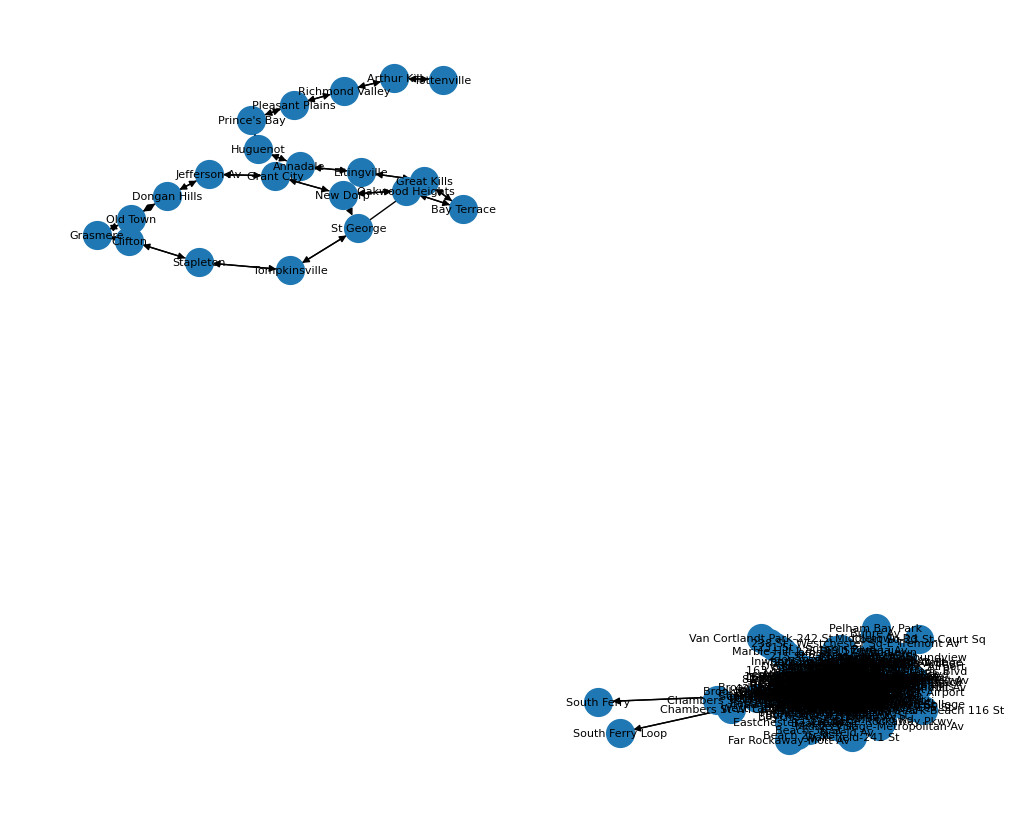

In [6]:
transport_graph = nx.read_gml("subway_graph_bidirectional.gml")
transport_traffic = copy.deepcopy(transport_graph)

def clean_nodes(src): 
    # print(src)
    # to remove brackets denoting connecting lines @ stations
    src = re.sub(r"\s*\([^)]*\)", "", src)
    src = re.sub(r"\s*/\s*", "-", src)
    # print(src)
    return src

for _, row in tqdm(df_agg.iterrows()):

    src = clean_nodes(row["Origin Station Complex Name"])
    dst = clean_nodes(row["Destination Station Complex Name"])

    est_ridership = row["Estimated Average Ridership"]

    try:
        if nx.has_path(transport_graph, src, dst): 
            paths = list(nx.all_shortest_paths(transport_graph, src, dst))
            if not paths:
                continue

            weight_increment = est_ridership / len(paths)

            for path in paths:
                for u, v in zip(path[:-1], path[1:]):
                    if transport_traffic.has_edge(u, v):
                        current_weight = transport_traffic[u][v].get("weight", 0)
                        transport_traffic[u][v]["weight"] = current_weight + weight_increment
                    else:
                        print("you're literally schewpeed")
    except Exception as e: 
        print(e)


plt.figure(figsize=(10, 8))
pos = nx.spring_layout(transport_traffic, seed=42)
nx.draw(transport_traffic, pos, with_labels=True, node_size=400, font_size=8)
plt.show()

In [7]:
nx.write_gml(transport_traffic, "subway_graph_weekday_weekend_bidirectional.gml")

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

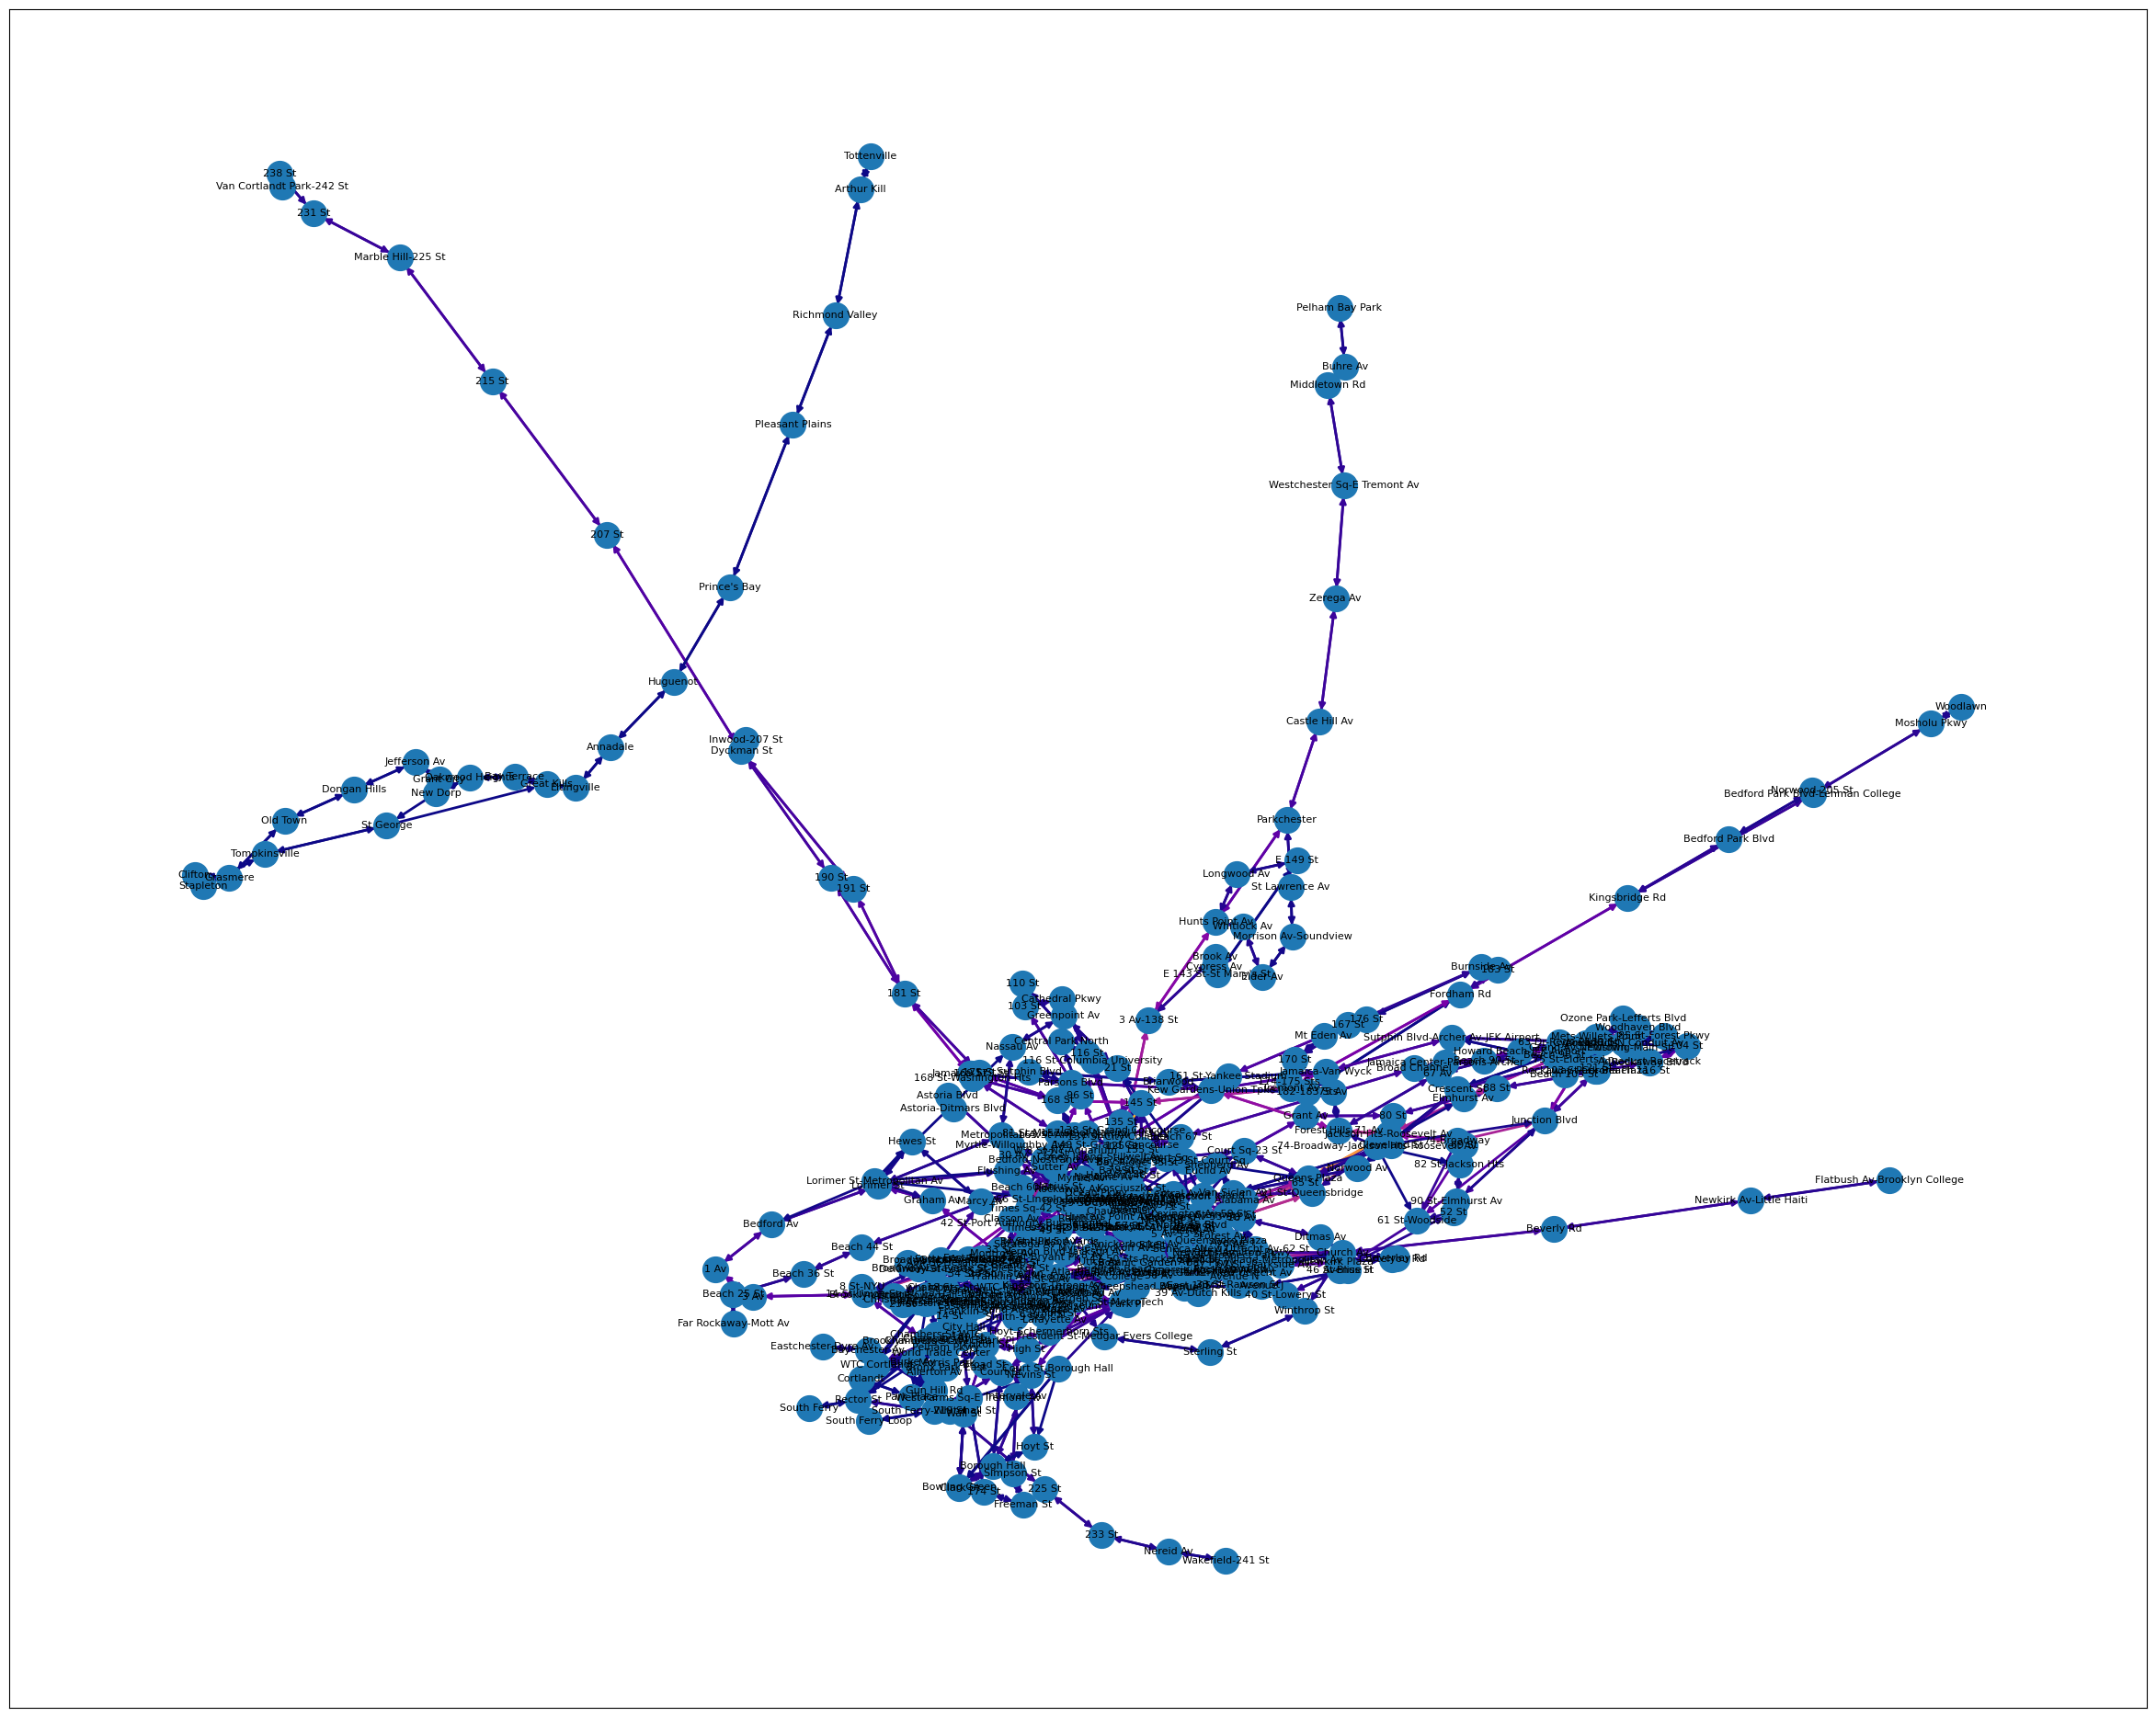

In [8]:
plt.figure(figsize=(30, 24))

pos = nx.spring_layout(transport_traffic, seed=42, k=0.001)

# extract edge weights
weights = [d.get("weight", 0) for (_, _, d) in transport_traffic.edges(data=True)]

# draw nodes
nx.draw_networkx_nodes(transport_traffic, pos, node_size=400)

# draw edges with colormap based on weights
edges = nx.draw_networkx_edges(
    transport_traffic,
    pos,
    edge_color=weights,
    edge_cmap=plt.cm.plasma,       # or 'viridis', 'inferno', etc.
    edge_vmin=min(weights),
    edge_vmax=max(weights),
    width=2
)

# draw labels
nx.draw_networkx_labels(transport_traffic, pos, font_size=8)

# add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma,
                           norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
sm.set_array([])
plt.colorbar(sm, label="Edge Weight Magnitude")

plt.axis("off")
plt.show()


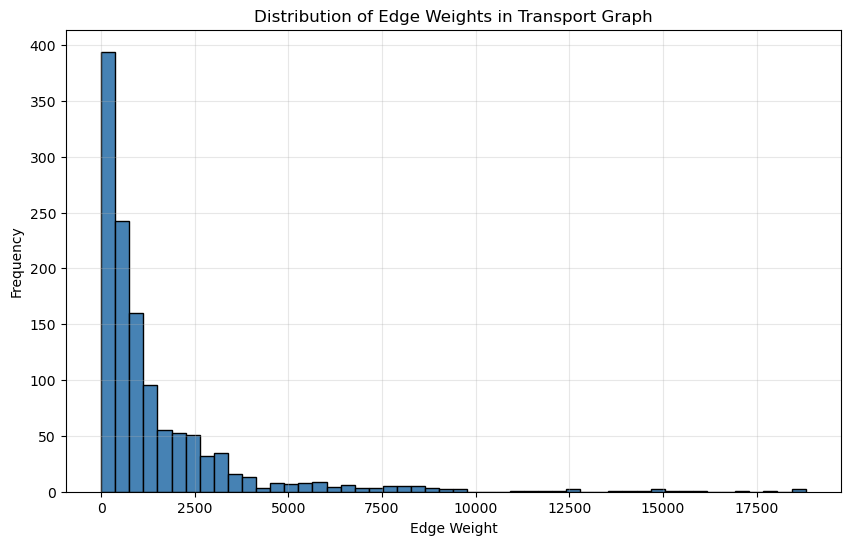

In [ ]:
weights = [d.get("weight", 0) for _, _, d in transport_traffic.edges(data=True)]

plt.figure(figsize=(10, 6))
plt.hist(weights, bins=50, color="steelblue", edgecolor="black")
plt.title("Distribution of Edge Weights in Transport Graph")
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


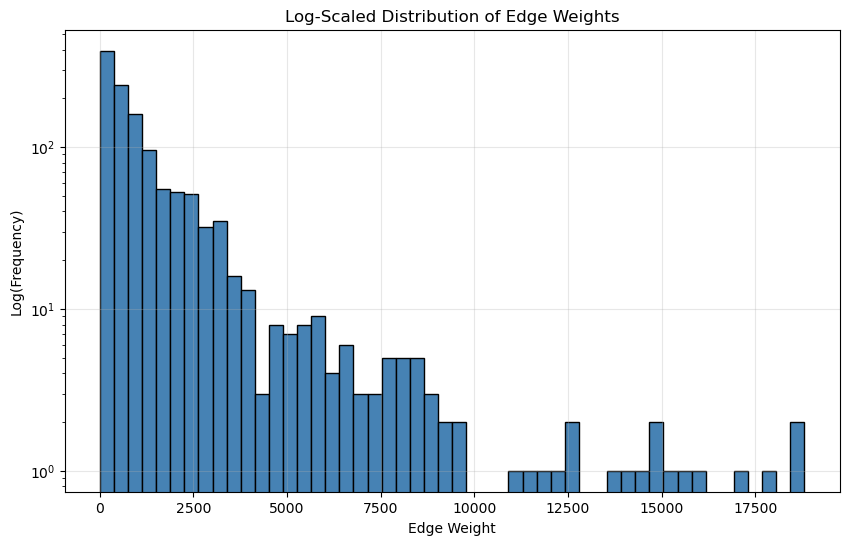

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(weights, bins=50, color="steelblue", edgecolor="black", log=True)
plt.title("Log-Scaled Distribution of Edge Weights")
plt.xlabel("Edge Weight")
plt.ylabel("Log(Frequency)")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
def make_line(row):
    return LineString([
        (row['Origin Longitude'], row['Origin Latitude']),
        (row['Destination Longitude'], row['Destination Latitude'])
    ])

gdf = gpd.GeoDataFrame(df_agg, geometry=df_agg.apply(make_line, axis=1), crs="EPSG:4326")


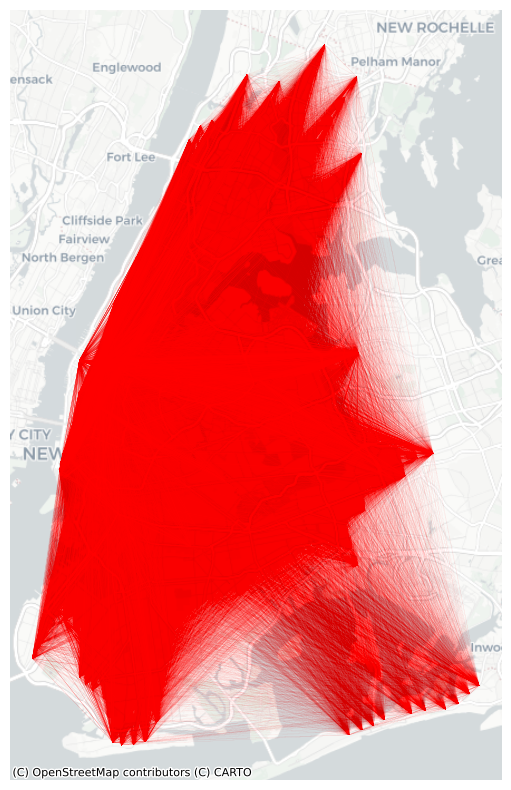

In [ ]:
gdf_merc = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_merc.plot(ax=ax, linewidth=gdf_merc['Estimated Average Ridership'] / gdf_merc['Estimated Average Ridership'].max() * 5, color='red', alpha=0.6)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.show()

In [ ]:

transport_traffic[transport_traffic["Destination Station Complex Name"] == "Bryant Pk-5 Av"]

AttributeError: 'DiGraph' object has no attribute 'columns'

In [ ]:
inflow = dict(transport_traffic.in_degree(weight="weight"))
outflow = dict(transport_traffic.out_degree(weight="weight"))

traffic_df = pd.DataFrame({
    "Station": list(transport_traffic.nodes()),
    "Inflow": [inflow.get(n, 0) for n in transport_traffic.nodes()],
    "Outflow": [outflow.get(n, 0) for n in transport_traffic.nodes()]
})

print(traffic_df)

2468.9106086060365
                       Station        Inflow       Outflow
0    Van Cortlandt Park-242 St    519.344558    523.736745
1                       238 St   1465.872440   1445.944947
2                       231 St   2441.215616   2409.661519
3           Marble Hill-225 St   3389.847355   3382.516537
4                       215 St   4062.389464   4032.300425
..                         ...           ...           ...
390         Lexington Av-63 St  10260.466617  10081.304683
391         Lexington Av-59 St  23455.461063  23055.289838
392              WTC Cortlandt   1942.464731   1832.097397
393       Times Sq-42 St-42 St      0.000000   8440.179943
394             Bryant Pk-5 Av      0.000000   2468.910609

[395 rows x 3 columns]
